# CS189 : Introduction to Machine Learning
## Homework 6
### SID : 23274190  Name : Hye Soo Choi

#### Neural Networks for MNIST Digit Recognition
In this homework, we will implement neural networks to classify handwritten digits using raw pixels as features. We will be using the MNIST digits dataset that you used in previous homework assignments. The state-of-the-art error rate on this dataset using deep convolutional neural networks is around 0.5%. For this assignment, we should, with appropriate parameter settings, get approximately or better than 6% error using a neural network with one hidden layer.

In [1]:
import scipy.io as sio
import numpy as np
import numpy.random as nr
from sklearn import preprocessing

#### Preprocessing

We import the data and transform each label between 0 and 9 to a vector of length $10$ which has single $1$ in the position of true class and $0$ everywhere else. 

In [2]:
train_data = sio.loadmat('./dataset/train.mat')
test_data = sio.loadmat('./dataset/test.mat')

tr_img_orig = train_data['train_images']
tr_lb_num = train_data['train_labels'][:,0]
tr_img = np.reshape(tr_img_orig, (784, 60000), order = 'F')

ts_img = np.reshape(np.swapaxes(np.transpose(test_data['test_images']),0,1), (784, 10000), order = 'F')


temp_lb = np.zeros((len(tr_lb_num),10))

for i in np.arange(len(tr_lb_num)):
    j = tr_lb_num[i]
    temp_lb[i,j] = 1

tr_lb = temp_lb

In [3]:
data =train_data['train_images'][:,:,20000]
from PIL import Image
from matplotlib import cm
data =train_data['train_images'][:,:,20000]
im = Image.fromarray(np.uint8(cm.gist_earth(data)*255))
im.save('out.png')


data =np.swapaxes(np.transpose(test_data['test_images']),0,1)[:,:,5000]
im = Image.fromarray(np.uint8(cm.gist_earth(data)*255))
im.save('out1.png')

Then, we normalize, or standardize, all feature vectors.

In [4]:
all_img = np.append(tr_img, ts_img, axis = 1)
all_img = all_img.astype(float) # change data type from int to float, in order to 
                                # facilitate calculations for standardization
all_img = preprocessing.scale(all_img, axis = 1)

ts_img = all_img[:, 60000:70000]
tr_img = all_img[:, 0:60000]
valid_ind = nr.choice(60000, 10000, replace = False)
vd_img = tr_img[: , valid_ind]
tr_img = tr_img[:, np.setdiff1d(np.arange(60000), valid_ind)]
vd_lb = tr_lb[valid_ind, :]
tr_lb = tr_lb[np.setdiff1d(np.arange(60000), valid_ind), :]
vd_lb_num = tr_lb_num[valid_ind]
tr_lb_num = tr_lb_num [np.setdiff1d(np.arange(60000), valid_ind)]

#### Neural Network
In this assignment, we are asked to implement a neural network with one hidden layer.
1.  We will be using a hidden layer of size 200. Let $n_{in} = 784$, the number of features for the digits class. Let $n_{hid} = 200$, the size of the hidden layer. Finally, let $n_{out}$ = 10, the number of classes. Then, we will have $n_{in} + 1$ units in the input layer, $n_{hid} + 1$ units in the hidden layer, and $n_{out}$ units in the output layer. The input and hidden layers have one additional unit which always takes a value of $1$ to represent bias. The output layer size is set to the number of classes. Each label will have to be transformed to a vector of length $10$ which has a single $1$ in the position of the true class and $0$ everywhere else.

2. The parameters of this model are the following:
-  $V$ , a $n_{hid}$-by-($n_{in} + 1$) matrix where the $(i; j)$-entry represents the weight connecting the $j$-th unit in the input layer to the $i$-th unit in the hidden layer. The $i$-th row of $V$ represents the ensemble of weights feeding into the $i$-th hidden unit. Note: there is an additional row for weights connecting the bias term to each unit in the hidden layer.
- $W$, a $n_{out}$-by-($n_{hid} + 1$) matrix where the (i; j)-entry represents the weight connecting the j-th unit in the hidden layer to the i-th unit in the output layer. The i-th row of W represents the ensemble of weights feeding into the $i$-th output unit. Note: again there is an additional row for weights connecting the bias term to each unit in the output layer.

#### Initialization of Weights

We initialize your weights with random values. This allows us to break
symmetry that occurs when all weights are initialized to 0. We initialize by drawing values from a uniform distribution from $[-0.01, 0.01]$ or from a Gaussian distribution with mean 0 and variance $0.01^2$.



In [5]:
nr.seed(0)
n_in = 784
n_hid = 200
n_out = 10
epsilon = 0.01
V0 = nr.normal(scale = epsilon, size = (n_hid, n_in + 1))
W0 = nr.normal(scale = epsilon, size = (n_out, n_hid + 1))

#### Adding one additional unit which always takes a value of 1 to represent bias

In [6]:
def add_bias(mat):
    if len(mat.shape) > 1:
        ncol = mat.shape[1]
        temp = np.array([[1.0 for j in range(ncol)]])
        mat = np.append(mat, temp, axis = 0)
    else:
        mat = np.append(mat, [1.0], axis = 0)
    return mat

tr_img = add_bias(tr_img) # add one column of 1's to all data
ts_img = add_bias(ts_img)
vd_img = add_bias(vd_img)

#### Two loss functions : Mean-Squared Error and Cross-Entropy Error

In [7]:
def mean_squared(true, pred):
    temp = np.square(true - pred)
    err = np.sum(temp)
    return err/2

def cross_entropy(true, pred):
    n,k = true.shape
    ind = (true == 1)
    temp = np.sum(true[ind] * np.log(pred[ind])) + np.sum((1-true[~ind]) * np.log(1-pred[~ind]))
    err = - temp
    return err

We use tanh activation function for the hidden layer units and the sigmoid function for the output layer units.

In [8]:
   
def sigmoid_stb(mat):
    # Numerically-stable sigmoid function
    
    ind = (mat >= 0)
    temp = np.zeros(mat.shape)
    temp[ind] = 1/(1+np.exp(-mat[ind]))
    z =np.exp(mat[~ind])
    temp[~ind] = z /(1+z)
    
    return temp


#def sigmoid(mat):
#    temp = 1/(1+ np.exp(- mat))
#    return temp


#### Calculating the loss for coefficient matrices W and V 

Here we implement a fuction that takes in two coefficient matrices W and V, and returns the values of output units when we use two matrices W and V as coefficients of linear combination for the hidden layer units and for the output layer units, respectively, to train neural network.

In [9]:
def predict( V,W, img):
    temp = np.dot(V, img)
    hidden = np.tanh(temp)
    hidden = add_bias(hidden)
    temp = np.dot(W, hidden)
    return np.transpose(sigmoid_stb(temp))

def calculate_loss(V,W, img, true_label, loss_fun):
    pred_label = predict(V, W, img)
    loss = loss_fun(true_label, pred_label)
    return loss

def misclassification(V,W,img, true_num):
    pred = predict(V,W,img)
    pred_num = np.argmax(pred, axis = 1)
    return np.sum(pred_num != true_num)/len(true_num)
    

#### Back propagation in Stochastic Gradient Descent
The procedure of matrix $V$ influencing on the final output and thus the total mean squared error can be divided into several steps as follows:
$$
V \mapsto A = Vx \mapsto B = \tanh(A) \mapsto C = WB^* \mapsto D = sigmoid(C) \mapsto E =\frac{1}{2}||Y-D||_2^2.
$$
Therefore, stepwise,

\begin{align*}
\frac{\partial E}{\partial D} &= (D - Y),\\
\frac{\partial D}{\partial C} &= diag(D)(I-diag(D)),\\
\frac{\partial C}{\partial B} &= W^\top,\\
\frac{\partial B}{\partial A} &= I - diag(B^2),\\
\frac{\partial A}{\partial V_j} &= diag(x_j),\\
\frac{\partial C}{\partial W_j} &= diag(B^*_j)\\
\end{align*}
where $x$ is a $(n_{in} + 1)$-dim column vector, $V_j,W_j$ denotes the $j$th column of the matrix $V, W$, respectively, $B^*$ is the matrix that results from adding a row of $1$ to $B$. In case we use cross-entropy instead, 
$$
\frac{\partial E}{\partial D} = Y/D - (1-Y)/(1-D)
$$

In [10]:
def find_gradient(V,W, i, loss_fun_name):
    
    x = tr_img[:,i:i+1]
    y = np.transpose(tr_lb[i:i+1,:])
    A = np.dot(V, x)
    B = np.tanh(A)
    B_bias = add_bias(B)
    C = np.dot(W, B_bias)
    D = sigmoid_stb(C)

    I = np.identity(n_out)
    if loss_fun_name == 'mean_squared':
        dEdD = - y + D
    elif loss_fun_name == 'cross_entropy':
        ind = (y == 1)
        temp = np.zeros(y.shape)
        temp[ind] = - y[ind]/D[ind]
        temp[~ind] = (1-y[~ind])/(1-D[~ind])
        dEdD = temp
        

    dDdC = np.multiply(D, 1-D)
    dCdB = np.transpose(W[:, :n_hid])
    dBdA = 1- np.square(B)
    
    dEdC = np.multiply(dDdC, dEdD)
    dEdB = np.dot(dCdB, dEdC)
    dEdA = np.multiply(dBdA, dEdB)
    dEdV = np.array([])
    dEdW = np.array([])
 
    
    dAdV = x[:,0]
    dEdV = np.outer(dEdA[:,0], dAdV)

    dCdW = B_bias[:,0]
    dEdW = np.outer(dEdC[:,0], dCdW)

        
    return np.concatenate((dEdV.ravel('F'), dEdW.ravel('F')))

def column_to_matrix(vec, r, c):
    return vec.reshape((r,c), order = 'F')
    
def matrix_to_column(mat):
    return mat.ravel(order = 'F')

a = find_gradient(V0, W0, 2, 'mean_squared')
b = find_gradient(V0, W0, 2, 'cross_entropy')

#### Numerical Gradient Checking

In [11]:
def numerical_gradient(V, W, i, eps = 1e-8):
    grad = np.concatenate((matrix_to_column(V), matrix_to_column(W)))

    num_grad = np.zeros(grad.shape)
    temp = grad
    for j in range(len(grad)):
        
        temp[j] = grad[j] + eps
        V_temp = column_to_matrix(temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(temp[n_hid*(n_in + 1):], n_out, n_hid + 1)
        loss1 = calculate_loss(V_temp,W_temp, tr_img[:, i:i+1], tr_lb[i:i+1,:], mean_squared)
        

        temp[j] = grad[j] - 2 * eps
        V_temp = column_to_matrix(temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(temp[n_hid*(n_in + 1):], n_out, n_hid + 1)
        loss2 = calculate_loss(V_temp,W_temp, tr_img[:, i:i+1],tr_lb[i:i+1,:], mean_squared)
        
        num_grad[j] = (loss1-loss2)/(2*eps)
        temp = grad
        
    return num_grad
        
def norm(l):
    return np.sqrt(np.sum(np.square(l)))

num_grad = numerical_gradient(V0, W0, 2)


In [12]:
norm(a-num_grad)/norm(a + num_grad)

1.9019895521456657e-06

In [13]:
def numerical_gradient_cross_entropy(V, W, i, eps = 1e-8):
    grad = np.concatenate((matrix_to_column(V), matrix_to_column(W)))

    num_grad = np.zeros(grad.shape)
    temp = grad
    for j in range(len(grad)):
        
        temp[j] = grad[j] + eps
        V_temp = column_to_matrix(temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(temp[n_hid*(n_in + 1):], n_out, n_hid + 1)
        loss1 = calculate_loss(V_temp,W_temp, tr_img[:, i:i+1], tr_lb[i:i+1,:], cross_entropy)
        

        temp[j] = grad[j] - 2 * eps
        V_temp = column_to_matrix(temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(temp[n_hid*(n_in + 1):], n_out, n_hid + 1)
        loss2 = calculate_loss(V_temp,W_temp, tr_img[:, i:i+1],tr_lb[i:i+1,:], cross_entropy)
        
        num_grad[j] = (loss1-loss2)/(2*eps)
        temp = grad
        
    return num_grad
num_grad_cross = numerical_gradient_cross_entropy(V0, W0, 2)
norm(b-num_grad_cross)/norm(b+num_grad_cross)

1.9302602087102173e-06

This proves that our calculation to find a gradient is pretty accurate.

#### Train Neural Network by Stochastic gradient descent using Mean Squared loss / Cross-entropy

In [14]:
def train(V, W, img, true, index, start, end, step):
    n = len(true)
    V_temp = V
    W_temp = W
    
    VW_temp = np.concatenate((matrix_to_column(V), matrix_to_column(W)))
    
    for i in index[start * 1000: end * 1000]:
        grad = find_gradient(V_temp, W_temp, i, 'mean_squared')
        VW_temp = VW_temp - step * grad
        V_temp = column_to_matrix(VW_temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(VW_temp[n_hid*(n_in + 1):], n_out, n_hid + 1)

    return (V_temp, W_temp)
            
def train_cross_entropy(V, W, img, true, index, start, end, step):
    n = len(true)

    V_temp = V
    W_temp = W

    
    VW_temp = np.concatenate((matrix_to_column(V), matrix_to_column(W)))
    
    for i in index[start * 1000 : end * 1000]:
        grad = find_gradient(V_temp,W_temp, i, 'cross_entropy')
        VW_temp = VW_temp - step * grad
        V_temp = column_to_matrix(VW_temp[0:n_hid*(n_in + 1)], n_hid, n_in + 1)
        W_temp = column_to_matrix(VW_temp[n_hid*(n_in + 1):], n_out, n_hid + 1)

    return (V_temp, W_temp)        

#### Train with cross entropy

- Initial learning rate : 0.01
Every two epoch, we update learning rate by a factor of 0.5.
- Training time:
For each epoch, it took about 10 mins to run stochastic gradient descent. 50 mins in total.
- Stopping condition:
When classification accuracy on validation data starts to drop, we consider it as a sign of overfitting and stop to train.

In [15]:
V_temp = V0
W_temp = W0
ind = nr.choice(50000,50000, replace = False)
loss = []
misclass = []
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])

In [16]:
V1, W1, loss1, misclass1 = V_temp, W_temp, loss, misclass
misclassification(V1,W1,vd_img,vd_lb_num)

0.067199999999999996

In [18]:
V_temp = V1
W_temp = W1
ind = nr.choice(50000,50000, replace = False)
loss = loss1
misclass = misclass1
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])

In [20]:
V2, W2, loss2, misclass2 = V_temp, W_temp, loss, misclass
misclassification(V2,W2,vd_img,vd_lb_num)

0.0516

In [21]:
V_temp = V2
W_temp = W2
ind = nr.choice(50000,50000, replace = False)
loss = loss2
misclass = misclass2
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V3, W3, loss3, misclass3 = V_temp, W_temp, loss, misclass
misclassification(V3,W3,vd_img,vd_lb_num)    

0.043799999999999999

In [22]:
V_temp = V3
W_temp = W3
ind = nr.choice(50000,50000, replace = False)
loss = loss3
misclass = misclass3
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V4, W4, loss4, misclass4 = V_temp, W_temp, loss, misclass
misclassification(V4,W4,vd_img,vd_lb_num)    

0.040300000000000002

In [23]:
V_temp = V4
W_temp = W4
ind = nr.choice(50000,50000, replace = False)
loss = loss4
misclass = misclass4
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V5, W5, loss5, misclass5 = V_temp, W_temp, loss, misclass
misclassification(V5,W5,vd_img,vd_lb_num)    

0.038600000000000002

In [24]:
V_temp = V5
W_temp = W5
ind = nr.choice(50000,50000, replace = False)
loss = loss5
misclass = misclass5
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V6, W6, loss6, misclass6 = V_temp, W_temp, loss, misclass
misclassification(V6,W6,vd_img,vd_lb_num)   

0.036900000000000002

In [25]:
V_temp = V6
W_temp = W6
ind = nr.choice(50000,50000, replace = False)
loss = loss6
misclass = misclass6
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V7, W7, loss7, misclass7 = V_temp, W_temp, loss, misclass
misclassification(V7,W7,vd_img,vd_lb_num)   

0.0378

In [26]:
V_temp = V7
W_temp = W7
ind = nr.choice(50000,50000, replace = False)
loss = loss7
misclass = misclass7
for j in range(50):
    V_temp, W_temp = train_cross_entropy(V_temp, W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5*0.5)
    loss_temp = calculate_loss(V_temp, W_temp, tr_img, tr_lb, cross_entropy)
    mis_temp = misclassification(V_temp, W_temp, tr_img, tr_lb_num)
    loss = np.append(loss, [loss_temp])
    misclass= np.append(misclass, [mis_temp])
    
V8, W8, loss8, misclass8 = V_temp, W_temp, loss, misclass
misclassification(V8,W8,vd_img,vd_lb_num)  

0.037699999999999997

#### Train with Mean-Squared Error


- Initial learning rate : 0.01
Every two or three epoch, we update learning rate by a factor of 0.5.
- Training time:
For each epoch, it took less than 10 mins to run stochastic gradient descent. 60mins in total.
- Stopping condition:
When classification accuracy on validation data starts to drop, we consider it as a sign of overfitting and stop to train.

In [27]:
_V_temp = V0
_W_temp = W0
_loss = []
ind = nr.choice(50000,50000, replace = False)
_misclass = []
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V1, _W1, _loss1, _misclass1 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V1,_W1,vd_img,vd_lb_num)      
    

0.089999999999999997

In [28]:
_V_temp = _V1
_W_temp = _W1
_loss = _loss1
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass1
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V2, _W2, _loss2, _misclass2 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V1,_W1,vd_img,vd_lb_num)  

0.089999999999999997

In [29]:
_V_temp = _V2
_W_temp = _W2
_loss = _loss2
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass2
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V3, _W3, _loss3, _misclass3 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V3,_W3,vd_img,vd_lb_num) 

0.060600000000000001

In [30]:
_V_temp = _V3
_W_temp = _W3
_loss = _loss3
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass3
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V4, _W4, _loss4, _misclass4 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V4,_W4,vd_img,vd_lb_num) 

0.057299999999999997

In [31]:
_V_temp = _V4
_W_temp = _W4
_loss = _loss4
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass4
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V5, _W5, _loss5, _misclass5 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V5,_W5,vd_img,vd_lb_num) 

0.054800000000000001

In [32]:
_V_temp = _V5
_W_temp = _W5
_loss = _loss5
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass5
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V6, _W6, _loss6, _misclass6 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V6,_W6,vd_img,vd_lb_num) 

0.051799999999999999

In [33]:
_V_temp = _V6
_W_temp = _W6
_loss = _loss6
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass6
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V7, _W7, _loss7, _misclass7 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V7,_W7,vd_img,vd_lb_num) 

0.050000000000000003

In [34]:
_V_temp = _V7
_W_temp = _W7
_loss = _loss7
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass7
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V8, _W8, _loss8, _misclass8 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V8,_W8,vd_img,vd_lb_num) 

0.049200000000000001

In [35]:
_V_temp = _V8
_W_temp = _W8
_loss = _loss8
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass8
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V9, _W9, _loss9, _misclass9 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V9,_W9,vd_img,vd_lb_num) 

0.047600000000000003

In [36]:
_V_temp = _V9
_W_temp = _W9
_loss = _loss9
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass9
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V10, _W10, _loss10, _misclass10 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V10,_W10,vd_img,vd_lb_num)

0.047600000000000003

In [37]:
_V_temp = _V10
_W_temp = _W10
_loss = _loss10
ind = nr.choice(50000,50000, replace = False)
_misclass = _misclass10
for j in range(50):
    _V_temp, _W_temp = train(_V_temp, _W_temp, tr_img, tr_lb, ind, j, j+1, 0.01*0.5*0.5*0.5)
    loss_temp = calculate_loss(_V_temp, _W_temp, tr_img, tr_lb, mean_squared)
    mis_temp = misclassification(_V_temp, _W_temp, tr_img, tr_lb_num)
    _loss = np.append(_loss, [loss_temp])
    _misclass = np.append(_misclass, [mis_temp])
    
_V11, _W11, _loss11, _misclass11 = _V_temp, _W_temp, _loss, _misclass
misclassification(_V11,_W11,vd_img,vd_lb_num)

0.0458

#### Kaggle

- Cross_entropy: 0.96860
- Mean_squared: 0.96200

The classification accuracy on test data were very similar in cross entropy and mean squared loss, and the cross entropy gained slightly higher accuracy rate on test data. Considering the number of epoch by which we trained data, cross entropy seems more time-efficient.

In [38]:
pred_cross = predict(V7, W7, ts_img)
pred_num_cross = np.argmax(pred_cross,axis=1)
pred_cross_txt = np.asarray([[i+1, pred_num_cross[i]] for i in np.arange(10000)])
np.savetxt('pred_cross.csv',pred_cross_txt,fmt = '%1.u' , delimiter = ',', header = 'Id,Category',comments='')

In [39]:
pred_mean = predict(_V10, _W10, ts_img)
pred_num_mean = np.argmax(pred_mean,axis=1)
pred_mean_txt = np.asarray([[i+1, pred_num_mean[i]] for i in np.arange(10000)])
np.savetxt('pred_mean.csv',pred_mean_txt,fmt = '%1.u' , delimiter = ',', header = 'Id,Category',comments='')

#### Graph

Plots of total training error and classification accuracy on training set vs iteration. We compute the error or accuracy every 1000 iterations.

In [40]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

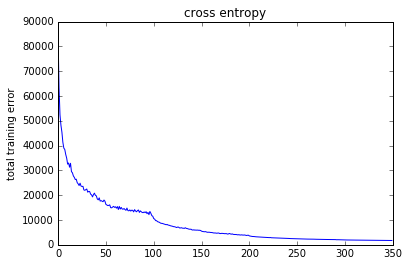

In [41]:
plt.plot(loss7)
plt.ylabel('total training error')
plt.title('cross entropy')
plt.show()

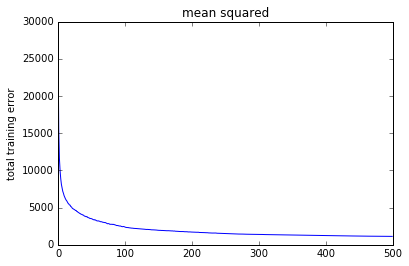

In [42]:
plt.plot(_loss10)
plt.ylabel('total training error')
plt.title('mean squared')
plt.show()

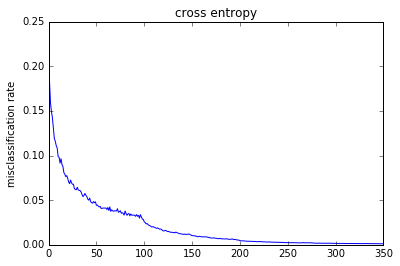

In [43]:
plt.plot(misclass7)
plt.ylabel('misclassification rate')
plt.title('cross entropy')
plt.show()

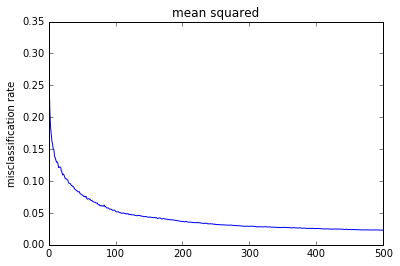

In [44]:
plt.plot(_misclass10)
plt.ylabel('misclassification rate')
plt.title('mean squared')
plt.show()